In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#!tar -xf '/content/drive/My Drive/Colab Notebooks/Generative models/Skins.tar' -C '/content/drive/My Drive/Colab Notebooks/Generative models'
# !ls '/content/drive/My Drive/Colab Notebooks/Generative models/Skins' > '/content/drive/My Drive/Colab Notebooks/Generative models/skins.txt'

ls: cannot open directory '/content/drive/My Drive/Colab Notebooks/Generative models/Skins': Input/output error


In [1]:
# DATA_DIR = "/content/drive/My Drive/Colab Notebooks/Generative models/"
DATA_DIR = "/mnt/p/datasets/Skins/"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## Dataset

In [3]:
class SkinsDataset(Dataset):
    """Minecraft skins dataset."""

    def __init__(self, names_file, img_dir, transform=None):
        self.names = pd.read_csv(names_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir,
                                self.names.iloc[idx, 0])
        image = io.imread(img_name)
        sample = image[:32, :, :3] / 255

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image).float()

In [5]:
def imshow(img, ax, name=None):
    img = np.transpose(img.numpy(), (1, 2, 0))
    ax.imshow(img)
    ax.axis('off')
    if name != None:
        plt.savefig(name + ".png")
    else:
        plt.show()

In [6]:
skins_dataset = SkinsDataset(names_file=DATA_DIR+"skins.txt", img_dir=DATA_DIR+"Skins/", transform=ToTensor())
dataloader = DataLoader(skins_dataset, batch_size=16,
                        shuffle=True, num_workers=4)

0 torch.Size([16, 3, 32, 64])


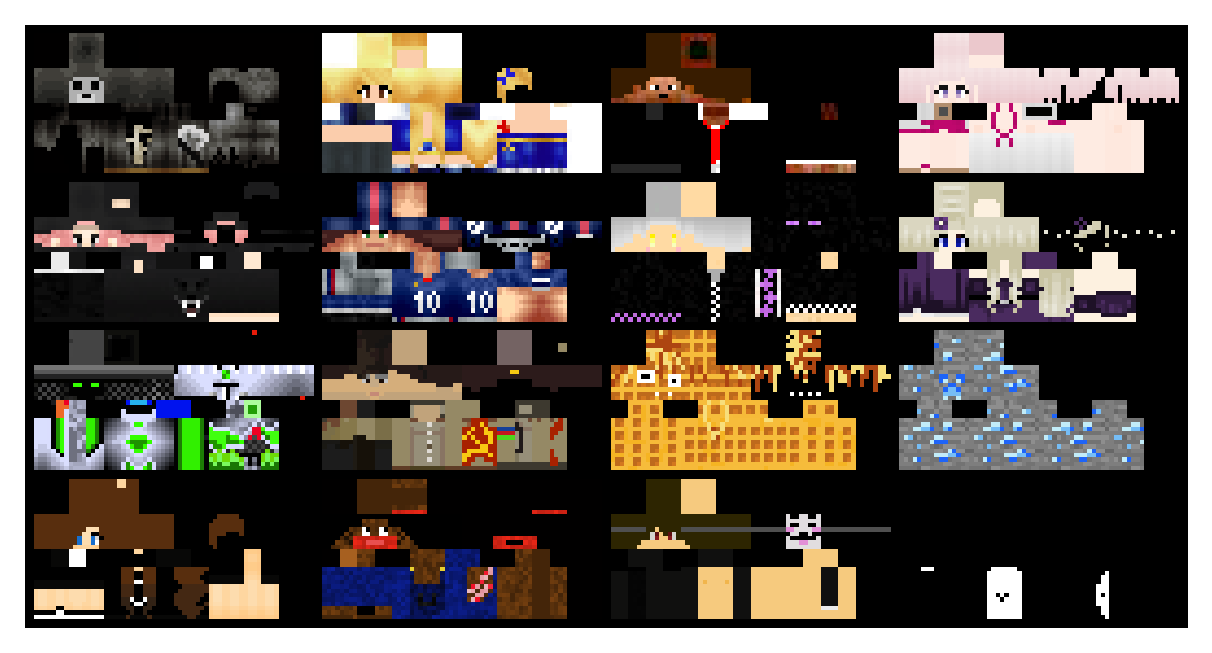

In [7]:
import torchvision

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched.size())

    if i_batch == 0:
        fig, ax = plt.subplots()
        fig.dpi = 250
        imshow(torchvision.utils.make_grid(sample_batched, nrow=4), ax)
        break


## Models


In [8]:
BATCH_SIZE = 16
LATENT   = 2
LATENT_2 = 2 #16x8

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.l1 = nn.Linear(in_features=LATENT, out_features=16*4*8)
        self.bl1 = nn.BatchNorm2d(16)

        self.c1 = nn.ConvTranspose2d(16, 128, (4, 4), 2, 1)  # 8x16
        self.b1 = nn.BatchNorm2d(128)
        
        self.l2 = nn.Linear(in_features=LATENT_2, out_features=16*8*16)
        self.c2 = nn.ConvTranspose2d(128+16, 256, (4, 4), 2, 1)  # 16x32
        self.b2 = nn.BatchNorm2d(256)

        self.c3 = nn.ConvTranspose2d(256, 64, (4, 4), 2, 1)  # 32x64
        self.b3 = nn.BatchNorm2d(64)

        self.c4 = nn.ConvTranspose2d(64, 3, (3, 3), 1, 1)   # 32x64
 
        self.drop = nn.Dropout(p=0.3)

    def forward(self, z1, z2):
        x = self.l1(z1).view(-1, 16, 4, 8)
        x = self.bl1(x)
        x = F.leaky_relu(x)

        x = self.c1(x)
        x = self.b1(x)
        x = F.leaky_relu(x)
        
        z2 = self.l2(z2).view(-1, 16, 8, 16)
        z2 = F.leaky_relu(z2) 
        x = torch.cat((x, z2), dim=1)
        
        x = self.c2(x)
        x = self.b2(x)
        x = F.leaky_relu(x) 

        x = self.c3(x)
        x = self.b3(x)
        x = F.leaky_relu(x)
        
        x = self.c4(x)

        x = torch.sigmoid(x)
        return x

gen = Generator().cuda()

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.c1 = nn.Conv2d(3, 32, 4, 2, padding=1)  # 32x16
        self.b1 = nn.BatchNorm2d(32)

        self.c2 = nn.Conv2d(32, 128, 4, 2, padding=1)  # 16x8
        self.b2 = nn.BatchNorm2d(128)

        self.c3 = nn.Conv2d(128, 64, 4, 2, padding=1)  # 8x4
        self.b3 = nn.BatchNorm2d(64)
        
        self.c4 = nn.ConvTranspose2d(64, 64, 3, 1, padding=1)   # 8x4

        self.l1 = nn.Linear(in_features=64*8*4, out_features=8*8*4)
        self.l2 = nn.Linear(in_features=8*8*4, out_features=1)

        
        self.drop = nn.Dropout(p=0.3)
        
    def forward(self, z1):
        x = self.c1(z1)
        x = self.b1(x)
        x = F.leaky_relu(x)

        x = self.c2(x)
        x = self.b2(x)
        x = F.leaky_relu(x)

        x = self.c3(x)
        x = self.b3(x)
        x = F.leaky_relu(x)
        
        x = self.c4(x)
        x = F.leaky_relu(x)
        x = x.view(-1, 64*8*4)

        x = self.l1(x)
        x = F.leaky_relu(x)
        x = self.drop(x)
        
        x = self.l2(x)

        return torch.sigmoid(x)
    
dis = Discriminator().cuda()

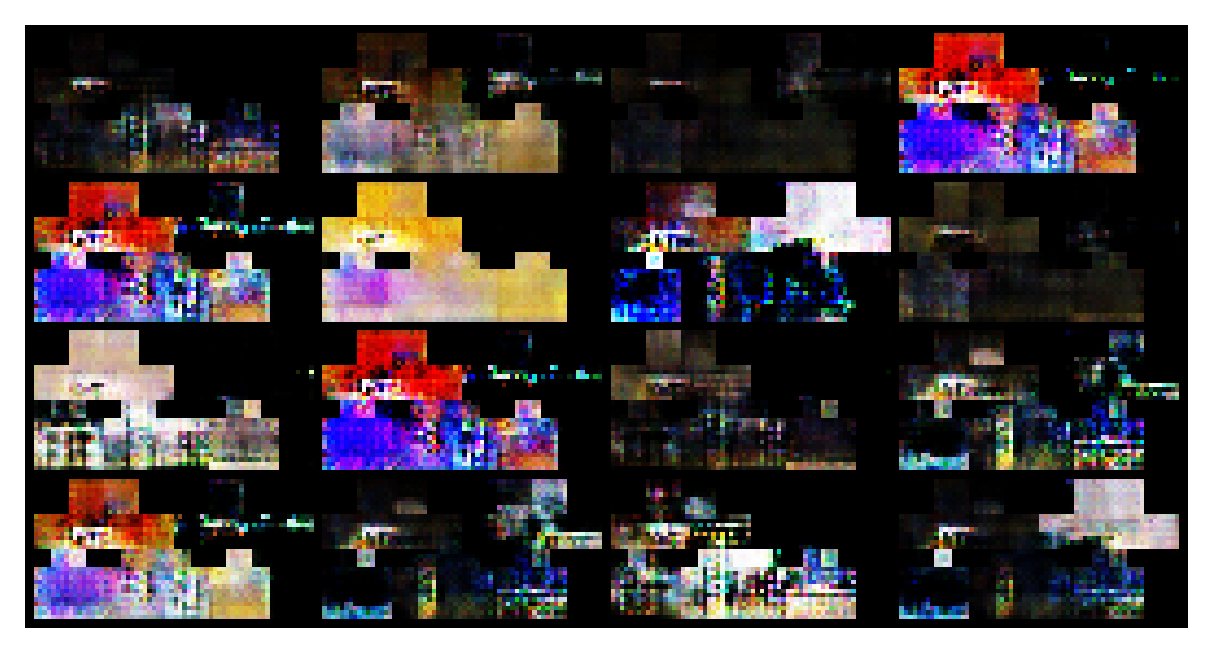

tensor([[0.2496],
        [0.3397],
        [0.3409],
        [0.2257],
        [0.1843],
        [0.2788],
        [0.0775],
        [0.4698],
        [0.2093],
        [0.3119],
        [0.4599],
        [0.5377],
        [0.4348],
        [0.2545],
        [0.2800],
        [0.0944]], device='cuda:0')


In [51]:
data = gen(torch.randn(16, LATENT).cuda(), torch.randn(16, LATENT_2).cuda()).cpu()
fig, ax = plt.subplots()
fig.dpi = 250
imshow(torchvision.utils.make_grid(data.detach(), nrow=4), ax)
print(dis(data.cuda()).detach())
plt.close()

## Learning

In [15]:
losses_g = []
losses_d = []
dis_errors = []
gen_errors = []
dis_err_plt = []
gen_err_plt = []
gen = Generator().cuda()
dis = Discriminator().cuda()

fixed_noise  = (torch.randn(8, LATENT).cuda(), torch.randn(8, LATENT_2).cuda())

real_label = 0.9
fake_label = 0.0

In [16]:
import torch.optim as optim

op_gen = optim.Adam(gen.parameters(), lr=0.00006)
op_dis = optim.Adam(dis.parameters(), lr=0.00005) 
criterion = nn.BCELoss()

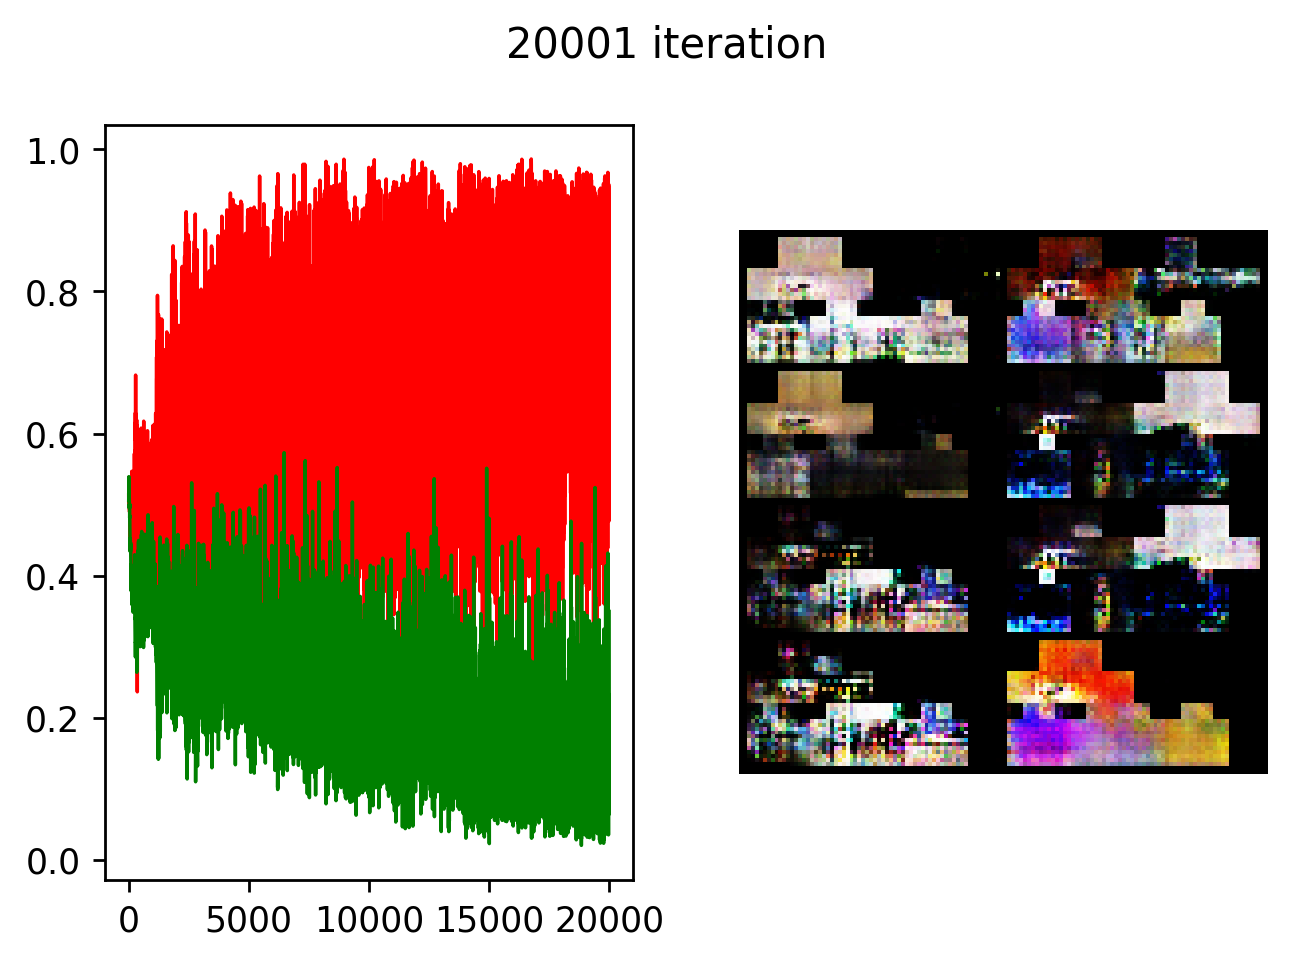

In [17]:
dataiter = iter(dataloader)
stepsD = 1
stepsG = 1

for epoch in range(20000):
    try:
        # Discriminator
        for i in range(stepsD):
            op_gen.zero_grad()
            op_dis.zero_grad()
            # True
            imgs = next(dataiter)
            
            o = dis(imgs.cuda())
            dis_err_plt.append(o.mean())

            derr = criterion(o.view(-1), torch.full((imgs.size()[0],), real_label).cuda())
            derr.backward()
            # False
            z = (torch.randn(imgs.size()[0], LATENT).cuda(), torch.randn(imgs.size()[0], LATENT_2).cuda())
            o = dis(gen(*z))
            gerr = criterion(o.view(-1), torch.full((imgs.size()[0],), fake_label).cuda())
            gerr.backward()
            
            
            op_dis.step()
#             if dis_errors[-1] > 0.6:
#                 break
#         losses_d.append(loss)
#         dis_err_plt.append(dis_errors[-1])
        # Generator
        for i in range(stepsG): 
            op_dis.zero_grad()
            op_gen.zero_grad()

            z = (torch.randn(imgs.size()[0], LATENT).cuda(), torch.randn(imgs.size()[0], LATENT_2).cuda())
            o = dis(gen(*z))
            gerr = criterion(o.view(-1), torch.full((imgs.size()[0],), real_label).cuda())
            gerr.backward()
            op_gen.step()
        gen_err_plt.append(o.mean())
#             if gen_errors[-1] > 0.7:
#                 break
#         losses_g.append(loss)
#         gen_err_plt.append(gen_errors[-1])

            
    except StopIteration:
        dataiter = iter(dataloader)
    if epoch % 5000 == 4999:
        plt.cla()
        plt.clf()
        plt.close("all")
        g_w = gen.state_dict()
        d_w = dis.state_dict()
        torch.save(g_w, 'gen_{0}.pth'.format(epoch))
        torch.save(d_w, 'dis_{0}.pth'.format(epoch))
    if epoch % 250 == 249:
        clear_output(wait=True)
#         print('[{:4d}] {:.10f} : {:.10f} |=| {:.10f} : {:.10f}'.format(len(dis_err_plt), losses_d[-1], losses_g[-1], dis_errors[-1], gen_errors[-1]))
        data = gen(*fixed_noise).cpu()
        fig, axs = plt.subplots(1, 2)
        fig.dpi = 250
        fig.suptitle("{} iteration".format(len(dis_err_plt)+1))
        axs[0].plot(dis_err_plt, color='red',linewidth=1.0)
        axs[0].plot(gen_err_plt, color='green',linewidth=1.0)
        imshow(torchvision.utils.make_grid(data.detach(), nrow=2), axs[1]) # , './imgs/'+str(epoch+1+200)



In [40]:
g_w = gen.state_dict()
d_w = dis.state_dict()
torch.save(g_w, 'mc_gen.pth')
torch.save(d_w, 'mc_dis.pth')

In [42]:
g_w = torch.load('mc_gen.pth')
d_w = torch.load('mc_dis.pth')
gen.load_state_dict(g_w)
dis.load_state_dict(d_w)

<All keys matched successfully>